# GPT-2 Classifier with target LM pretraining

In this notebook we will train a GPT-2 classifier for the proxy task using the pretrained target language model for initialization.  The language model is trained in 05_gpt2_lm.ipynb.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import GPT2Model, GPT2DoubleHeadsModel, GPT2Config
import eval_models
from train_utils import *

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.59
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
torch.cuda.set_device(0)

### Prep databunch

In [5]:
bs = 64
seed = 42
tok_model_dir = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_target'
max_seq_len = 512

In [6]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [7]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')
cls_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('</s>')

In [8]:
bpe_path = Path('/home/tjtsai/.fastai/data/bscore_lm/bpe_data')
train_df = pd.read_csv(bpe_path/'train64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid64.char.csv')
test_df = pd.read_csv(bpe_path/'test64.char.csv')

In [9]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

### Train Classifier

In [10]:
model_class, config_class = GPT2Model, GPT2Config

In [11]:
lang_model_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/models/gpt2_train-target_lm'
config = config_class.from_pretrained(lang_model_path)
config.num_labels = data_clas.c

In [12]:
transformer_model = model_class.from_pretrained(lang_model_path, config = config)
gpt2_clas = GPT2Classifier(transformer_model, config, pad_idx, cls_idx)

In [ ]:
# learner.destroy()
# torch.cuda.empty_cache()

In [13]:
learner = Learner(data_clas, gpt2_clas, metrics=[accuracy, FBeta(average = 'macro', beta=1)])

In [14]:
list_layers = [learner.model.transformer.wte, 
               learner.model.transformer.wpe, 
               learner.model.transformer.h[0],
               learner.model.transformer.h[1],
               learner.model.transformer.h[2],
               learner.model.transformer.h[3],
               learner.model.transformer.h[4],
               learner.model.transformer.h[5],
               learner.model.transformer.ln_f]

In [15]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30000, 768)
), Sequential(
  (0): Embedding(514, 768)
  (1): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1D()
  (7): Conv1D()
  (8): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1D()
  (7): Conv1D()
  (8): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1

In [16]:
seed_all(seed)

In [17]:
learner.freeze_to(-1)

In [18]:
learner.summary()

GPT2Classifier
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [144, 768]           23,040,000 False     
______________________________________________________________________
Embedding            [144, 768]           394,752    False     
______________________________________________________________________
Dropout              [144, 768]           0          False     
______________________________________________________________________
LayerNorm            [144, 768]           1,536      False     
______________________________________________________________________
Conv1D               [144, 2304]          1,771,776  False     
______________________________________________________________________
Conv1D               [144, 768]           590,592    False     
______________________________________________________________________
Dropout              [12, 144, 144]       0          False     
_______________________________________________

In [19]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.29E-03


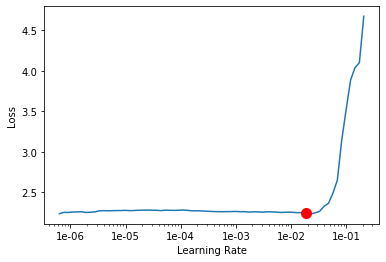

In [20]:
learner.recorder.plot(suggestion=True)

In [21]:
lr = 1e-3

In [22]:
learner.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.816693,1.758219,0.381111,0.329669,00:52
1,1.672011,1.653562,0.385093,0.350460,00:53
2,1.648362,1.621017,0.405463,0.393118,00:54
3,1.588037,1.616477,0.405370,0.388000,00:54


In [23]:
learner.freeze_to(-2)
learner.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.547897,1.647072,0.401389,0.380812,01:04
1,1.402948,1.629606,0.413519,0.391815,01:06
2,1.272394,1.599716,0.431759,0.420965,01:06


In [24]:
learner.freeze_to(-3)
learner.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.292888,1.608007,0.427037,0.415387,01:16
1,1.081885,1.654047,0.442315,0.430837,01:18


In [29]:
learner.freeze_to(-4)
learner.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.987884,1.748752,0.435648,0.423855,01:28
1,0.856152,1.821051,0.442315,0.432875,01:30


In [30]:
learner.save('gpt2_train-target_clas')
#learner.load('gpt2_train-target_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [31]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [32]:
learner.validate(data_clas_test.valid_dl)

[1.8054407, tensor(0.4524), tensor(0.4424)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [33]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

In [34]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [35]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.5782208442687988, 0.574386477470398),
 (0.5359164269159149, 0.5204767651838744))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [36]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

In [37]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [38]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.5498466491699219, 0.5904908180236816),
 (0.5056355226515638, 0.5047555544561575))

### Error Analysis

In [39]:
interp = ClassificationInterpretation.from_learner(learner)

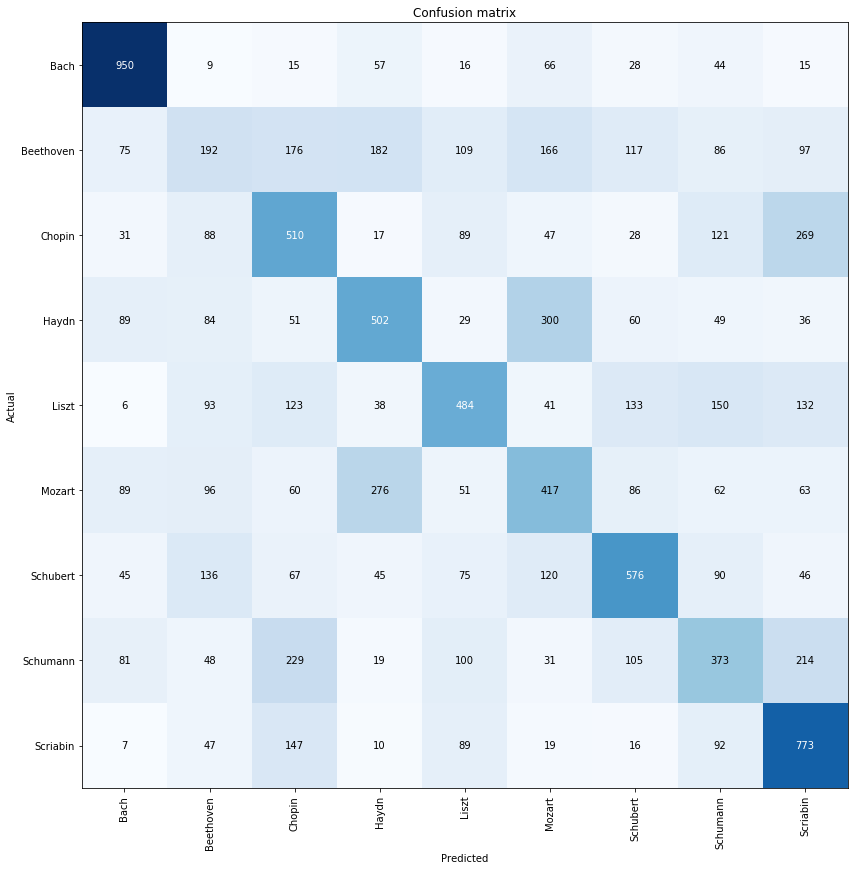

In [40]:
interp.plot_confusion_matrix(figsize=(12,12))